### Process the Snow Course Data from AK
This notebook takes downloaded snow course data and turns it into the
inputs needed for the calibration workflow

In [22]:
import pandas as pd
import numpy as np
import geopandas as gpd
import requests
from shapely import geometry as sgeom


# Import the snow course data downloaded from Dave
# NOTE: I altered the date column to be year, mon, day
pd_data = pd.read_csv('/nfs/attic/dfh/2020_NPRB/data/snow_course/AK_snow_course_data.csv')
sc = pd.DataFrame(pd_data)

# calibration information 
cal_st = pd.to_datetime('09012009', format='%m%d%Y')
cal_ed = pd.to_datetime('09302014', format='%m%d%Y')

# get domain reference information
domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
domains = domains_resp.json()

# Rename the columns and print some things to the console
sc.columns = ['mon','day','year','id','name','snod','date','lat','lon']
print(sc.nunique(),'Num of Unique Stations')

# Subset the dataframe to print out the list of unique stations
stations = sc.groupby('id').first()
#add station id to df
stations['code']=stations.index
print(len(stations))

#add column with datetime for later data processing
sc['dt']= pd.to_datetime(dict(year=sc.year, month=sc.mon, day=sc.day))

# Save this station list for selection in QGIS
#stations.to_csv('AK_snow_course_station_list.csv')

mon      12
day       1
year     40
id      227
name    227
snod    155
date    175
lat     226
lon     227
dtype: int64 Num of Unique Stations
227


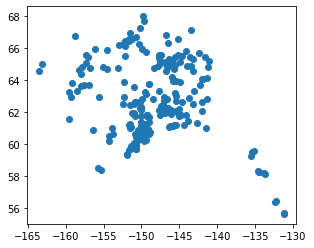

In [23]:
#convert the station list from above to points with geopandas
scgdf = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.lon, stations.lat),crs='epsg:4326')
scgdf.plot()

In [24]:
# reproject
new_box = box_gdf.to_crs(mod_proj)
new = scgdf.to_crs(mod_proj)

#clip snow course sites to domain bounding box
gdf = gpd.sjoin(new, new_box, how="inner")
gdf.drop(columns='index_right', inplace=True)
gdf.reset_index(drop=True, inplace=True)

In [25]:
# add column with domain name to each snow course location
# run all AK domains
domain_list = ['BEAU','BRIS','CHUK','JUNE','KLAW','SITK','TAKU','YUKO']

for domain in domain_list:
    print(domain)
  
    # bounding box
    Bbox = domains[domain]['Bbox']

    # Snotel projection
    stn_proj = domains[domain]['stn_proj']
    # model projection
    mod_proj = domains[domain]['mod_proj']

    # Convert the bounding box dictionary to a shapely Polygon geometry using sgeom.box
    box_sgeom = sgeom.box(Bbox['lonmin'], Bbox['latmin'], Bbox['lonmax'], Bbox['latmax'])
    box_gdf = gpd.GeoDataFrame(geometry=[box_sgeom], crs=stn_proj)
    # reproject
    new_box = box_gdf.to_crs(mod_proj)
    new_scgdf = scgdf.to_crs(mod_proj)

    #clip snow course sites to domain bounding box
    gdf_proj = gpd.sjoin(new_scgdf, new_box, how="inner")
    gdf_proj.drop(columns='index_right', inplace=True)
    gdf_proj.reset_index(drop=True, inplace=True)
    # add columns with projected coordinates 
    gdf_proj['easting'] = gdf_proj.geometry.x
    gdf_proj['northing'] = gdf_proj.geometry.y
    
    # reproject to  columns with projected coordinates 
    gdf = gdf_proj.to_crs(stn_proj)
    # drop columns with measurement-specific information
    gdf_clean = gdf.drop(columns=['mon', 'day', 'year', 'snod', 'date'])

    print(gdf_clean.name)
    
    if len(gdf_clean)>0:
        print('exporting geojson file')
        # Export the sites to files, for reuse
        out = '/nfs/attic/dfh/2020_NPRB/data/snow_course/'+domain+'/Snow_course_'+domain+'.geojson'
        gdf_clean.to_file(out, driver='GeoJSON')
        
        # save out depth data for each domain
        # figure out unique observation dates 
        dates = []
        for code in gdf_clean.code:
            obs = sc.where(sc.id == code).dropna().reset_index(drop=True)
            dates.extend(obs.dt.tolist())
        # unique dates
        uqdates = np.unique(dates)
        # unique sites
        nams = gdf_clean.code.tolist()

        #build array of depth data
        data = np.empty([len(uqdates),len(nams)])
        for d in range(len(uqdates)):
            for n in range(len(nams)):
                # convert from cm to m
                try:
                    data[d,n] = sc.snod[(sc.id == nams[n])&(sc.dt==uqdates[d])].values[0]/100
                except:
                    data[d,n] = np.nan
        #turn into dataframe
        df = pd.DataFrame(data, index=uqdates, columns = nams)
        
        # Export the depth data to files, for reuse
        print('exporting hs data file')
        outP = '/nfs/attic/dfh/2020_NPRB/data/snow_course/'+domain+'/Snow_course_'+domain+'_snod_m.csv'
        df.to_csv(outP)
        
        # clip to calibration period 
        df_clip = df[(df.index>=cal_st)&(df.index<cal_ed)]
        # drop rows and columns if all values are nan
        df_clip=df_clip.dropna(axis=1, how='all')
        df_clip=df_clip.dropna(axis=0, how='all')
        
        # Export the depth data to files, for reuse
        outP2 = '/nfs/attic/dfh/2020_NPRB/data/snow_course/'+domain+'/Snow_course_'+domain+'_snod_m_'+str(cal_st.year)+'_'+str(cal_ed.year)+'.csv'
        df_clip.to_csv(outP2)
        

BEAU
Series([], Name: name, dtype: object)
BRIS
0              Nikolai Creek
1             Bentalit Lodge
2               Nugget Bench
3                  Kantishna
4               Bridge Creek
5       Demonstration Forest
6        Anchor River Divide
7                 Eagle Lake
8              Mcneil Canyon
9                Port Graham
10                  Nanwalek
11                Cytex Pass
12                  Skwentna
13             Granite Point
14           Congahbuna Lake
15           Chuitna Plateau
16                Lone Ridge
17             Chelatna Lake
18           Purkeypile Mine
19          West Fork Yentna
20           Lake Minchumina
21            Telaquana Lake
22          Upper Twin Lakes
23          Little Mud River
24             Port Alsworth
25             Fishtrap Lake
26       Lower Nowitna River
27               Brooks Camp
28               Three Forks
29                   Mcgrath
30                Deer Creek
31           Hoholitna River
32              Upper In

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14, 10))
box_gdf.plot(ax=ax)
gdf.plot(ax=ax,color='r')

# BEAU swed data

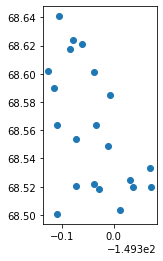

In [21]:
domain = 'BEAU'
# Import the snow course data
pd_data = pd.read_csv('/nfs/attic/dfh/2020_NPRB/data/snow_course/kuparuk/BEAU_snow_course_station_list.csv')
sc = pd.DataFrame(pd_data)
scgdf = gpd.GeoDataFrame(sc, geometry=gpd.points_from_xy(sc.longitude, sc.latitude),crs='epsg:4326')

# bounding box
Bbox = domains[domain]['Bbox']

# Snotel projection
stn_proj = domains[domain]['stn_proj']
# model projection
mod_proj = domains[domain]['mod_proj']

# Convert the bounding box dictionary to a shapely Polygon geometry using sgeom.box
box_sgeom = sgeom.box(Bbox['lonmin'], Bbox['latmin'], Bbox['lonmax'], Bbox['latmax'])
box_gdf = gpd.GeoDataFrame(geometry=[box_sgeom], crs=stn_proj)
# reproject
new_box = box_gdf.to_crs(mod_proj)
new_scgdf = scgdf.to_crs(mod_proj)

#clip snow course sites to domain bounding box
gdf_proj = gpd.sjoin(new_scgdf, new_box, how="inner")
gdf_proj.drop(columns='index_right', inplace=True)
gdf_proj.reset_index(drop=True, inplace=True)
# add columns with projected coordinates 
gdf_proj['easting'] = gdf_proj.geometry.x
gdf_proj['northing'] = gdf_proj.geometry.y

# reproject to  columns with projected coordinates 
gdf = gdf_proj.to_crs(stn_proj)
# drop columns with measurement-specific information
gdf_clean = gdf.drop(columns=['state','county'])

# Export the sites to files, for reuse
out = '/nfs/attic/dfh/2020_NPRB/data/snow_course/'+domain+'/Snow_course_'+domain+'.geojson'
gdf_clean.to_file(out, driver='GeoJSON')

scgdf.plot()

In [20]:
gdf

,state,county,code,latitude,longitude,elev,geometry,easting,northing
0,Alaska,North Slope,UK01,68.58485,-149.3063,912,POINT (-149.30630 68.58485),193136.734430,2.075896e+06
1,Alaska,North Slope,UK02,68.60103,-149.3381,834,POINT (-149.33810 68.60103),191705.086739,2.077585e+06
2,Alaska,North Slope,UK03,68.56392,-149.3352,827,POINT (-149.33520 68.56392),192111.709703,2.073507e+06
3,Alaska,North Slope,UK04,68.53360,-149.2298,912,POINT (-149.22980 68.53360),196685.323311,2.070475e+06
4,Alaska,North Slope,UK05,68.52003,-149.2267,1021,POINT (-149.22670 68.52003),196920.542227,2.068990e+06
5,Alaska,North Slope,UK06,68.51992,-149.2623,1050,POINT (-149.26230 68.51992),195455.246370,2.068873e+06
6,Alaska,North Slope,UK07,68.54890,-149.3112,848,POINT (-149.31120 68.54890),193215.469743,2.071922e+06
7,Alaska,North Slope,UK08,68.52220,-149.3380,968,POINT (-149.33800 68.52220),192319.731967,2.068903e+06
8,Alaska,North Slope,UK09,68.62412,-149.3790,762,POINT (-149.37900 68.62412),189848.711496,2.080011e+06
9,Alaska,North Slope,UK10,68.61733,-149.3839,801,POINT (-149.38390 68.61733),189699.784377,2.079249e+06
